In [118]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import numpy as np
import scipy
import matplotlib.pyplot as plt
import script.cloud_detection as cd

IMAGE_1_PATH = '../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits'
IMAGE_2_PATH = '../data/fits/box47346.223_5974.1909_21.600045_21.600045_0.0.fits'
IMAGE_3_PATH = '../data/fits/PROMISE-Q1-8micron-filled-v0_3-no-background.fits'
IMAGE_4_PATH = '../cnn/fits_for_annotation/box(50316.355, 6033.3671, 234.3168, 178.3296, 0.0).fits'

FITS_PATH = IMAGE_1_PATH

plt.style.use({"image.origin": "lower", "image.interpolation": "nearest"})

Filename: ../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   (120000, 12000)   float32   


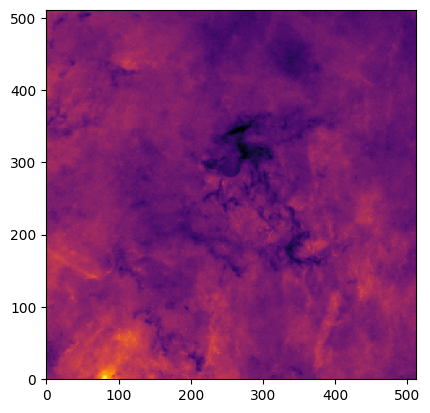

In [119]:
XSIZE: int = 512
YSIZE: int = 512
X: int = 49300
Y: int = 6000

# Open currimg and display info using memmap to not load the whole image into memory
imageHDU = fits.open(FITS_PATH, memmap=True, mode='denywrite')
imageHDU.info()

# Get display image as Numpy Array called data
data = np.array(imageHDU[0].data[Y:Y+YSIZE, X:X+XSIZE], dtype=np.float32) # type: ignore

# Display data
plt.imshow(data, cmap='inferno') #nipy_spectral, inferno, plasma, magma, viridis <- all good

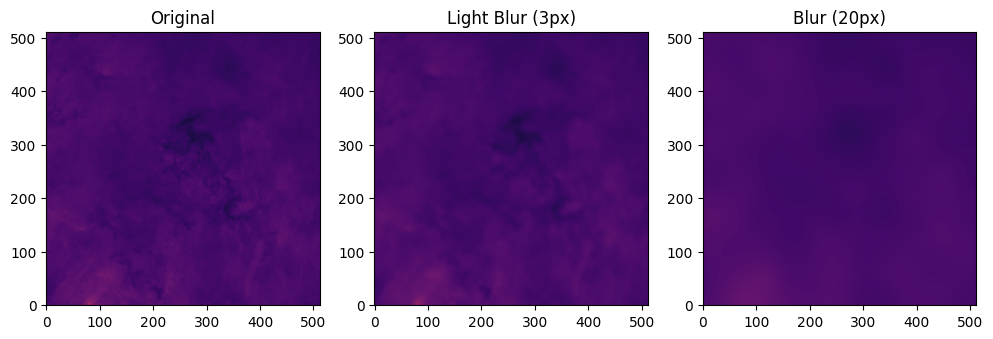

In [120]:
# gaussian blur
f, axarr = plt.subplots(1,3)
f.set_size_inches(12, 9)

lightblur = scipy.ndimage.gaussian_filter(data, sigma=3)
blur = scipy.ndimage.gaussian_filter(data, sigma=20)
plt.imshow(lightblur, cmap='inferno')
# notice how the dark spots are more visible (except for the small ones)

axarr[0].imshow(data, cmap='inferno', vmin=0, vmax=500)
axarr[0].set_title('Original')
axarr[1].imshow(lightblur, cmap='inferno', vmin=0, vmax=500)
axarr[1].set_title('Light Blur (3px)')
axarr[2].imshow(blur, cmap='inferno', vmin=0, vmax=500)
axarr[2].set_title('Blur (20px)');

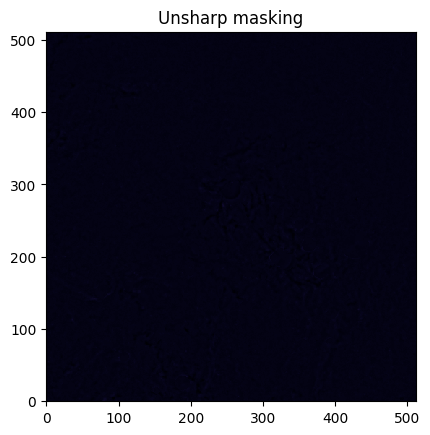

In [121]:
# subtract the two blurred images
test = data-lightblur
test = test - np.min(test)
plt.imshow(test, cmap='inferno', vmin=0, vmax=500)
plt.title("Unsharp masking");
# here the spots really pop out

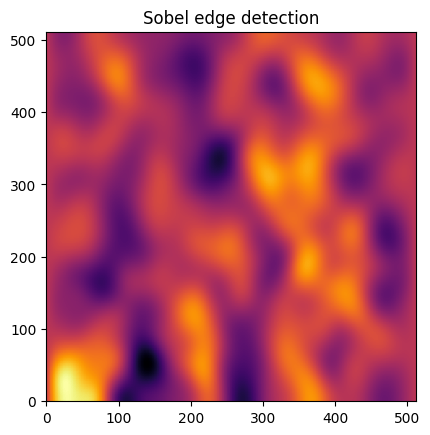

In [122]:
sobel = scipy.ndimage.sobel(blur) # edge detection 
sobel = sobel - np.min(sobel)

plt.imshow(sobel, cmap='inferno')
plt.title("Sobel edge detection");

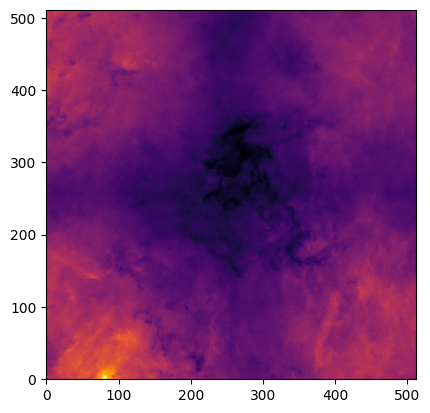

In [123]:
fourier = scipy.ndimage.fourier_uniform(data, 1)
plt.imshow(fourier, cmap='inferno')
# no clue what this does

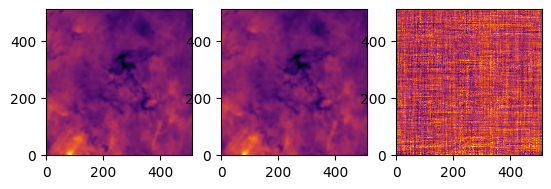

In [124]:
fft = np.fft.fft2(lightblur, axes=(0,1))

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.real(np.fft.ifft2(fft)), cmap='inferno')
axarr[1].imshow(np.abs(np.fft.ifft2(fft)), cmap='inferno')
axarr[2].imshow(np.imag(np.fft.ifft2(fft)), cmap='inferno')
# how does this work? is it because fft is aproximated?
# is abs correct? real is faster and imag is definitely wrong

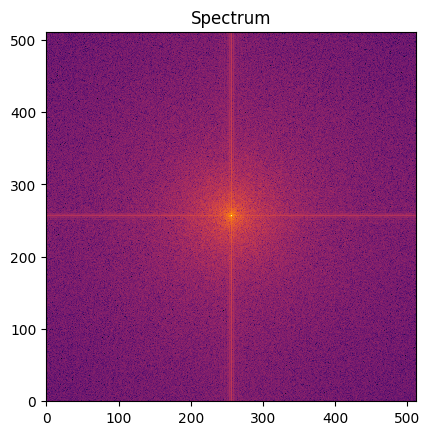

In [125]:
fft_shift = np.fft.fftshift(np.fft.fft2(data, axes=(0,1)))
mag = np.abs(fft_shift)
spec = np.log(mag) / 20
plt.imshow(spec, cmap='inferno') #spectrum
plt.title("Spectrum");
#ignore the white square hehe


# plot powet spectrunm

Max high pass:  78.79696216288791
Max low pass:  63.55935808023229
Max original:  192.22133


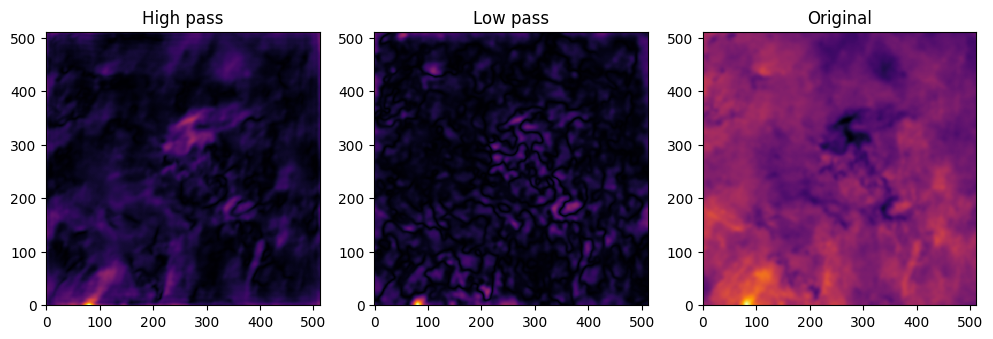

In [126]:
# super simple fft filter
fft = np.fft.fft2(lightblur, axes=(0,1))
fft_shift = np.fft.fftshift(fft)
f, axarr = plt.subplots(1,3)
f.set_size_inches(12, 9)

# high pass filter image
threshold = 50
fft[0:threshold, 0:threshold] = 0
# this is wonky and i am not sure it works

# low pass filter image, this is wierd
threshold = 5
fft_shift[XSIZE//2-threshold:XSIZE//2+threshold, XSIZE//2-threshold:XSIZE//2+threshold] = 0
# inverse fft and fftshift
ifft = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_shift)))

# plot beside each other
axarr[0].imshow(np.abs(np.fft.ifft2(fft)), cmap='inferno')
axarr[0].set_title('High pass')

axarr[1].imshow(ifft, cmap='inferno')
axarr[1].set_title('Low pass')

axarr[2].imshow(lightblur, cmap='inferno')
axarr[2].set_title('Original')
# doesn't work that good
print("Max high pass: ", np.max(np.abs(np.fft.ifft2(fft))))
print("Max low pass: ", np.max(ifft))
print("Max original: ", np.max(lightblur))

Sum low pass:  81.00000000000001
Sum low pass:  158.65830923343827
Max low pass:  1.0


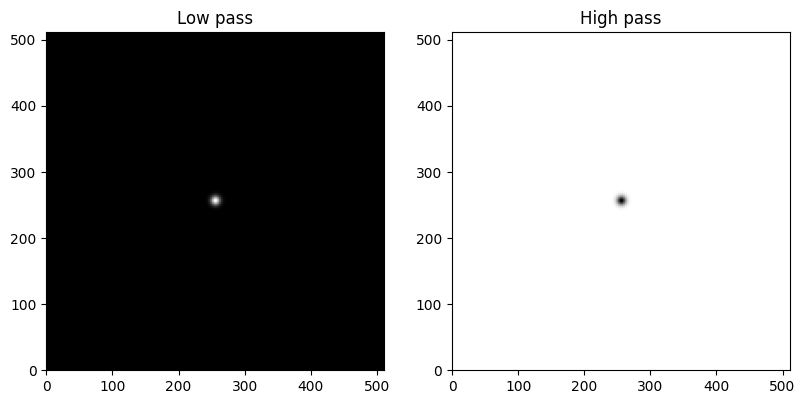

In [127]:
from astropy.convolution import Gaussian2DKernel

# create circular mask using numpy
Y_circ, X_circ = np.ogrid[:XSIZE, :YSIZE]

radius = 5

# Low pass
mask1 = (X_circ-XSIZE//2)**2 + (Y_circ-YSIZE//2)**2 <= radius**2
# High pass
mask2 = (X_circ-XSIZE//2)**2 + (Y_circ-YSIZE//2)**2 > radius**2
mask1 = mask1.astype(float) # to be able to blur
mask2 = mask2.astype(float) 
#blur
mask1 = scipy.ndimage.gaussian_filter(mask1, sigma=radius//4)
mask2 = scipy.ndimage.gaussian_filter(mask2, sigma=radius//4)

fig = plt.figure(figsize=(9.6, 4.8))
# ax = fig.add_subplot(1, 3, 1)
# ax.imshow(mask1, cmap='gray')
# ax.set_title('Numpy')

print("Sum low pass: ", np.sum(mask1))


# create it using Gaussian2DKernel
mask1 = Gaussian2DKernel(x_stddev=radius, y_stddev=radius, x_size=XSIZE, y_size=YSIZE).array
mask1 = mask1/np.max(mask1)
mask2 = (1 - mask1).clip(0, 1)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(mask1, cmap='gray', vmin=0, vmax=1)
ax.set_title('Low pass')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask2, cmap='gray', vmin=0, vmax=1)
ax.set_title('High pass')

print("Sum low pass: ", np.sum(mask1))
print("Max low pass: ", np.max(mask1))

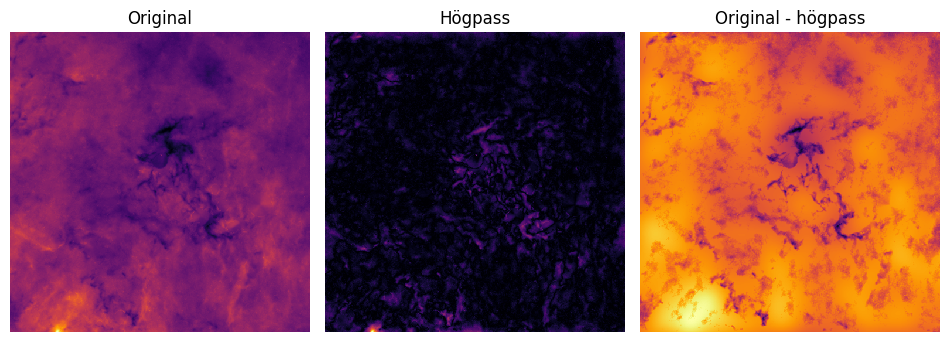

In [128]:
# high pass and fft again
fig, axarr = plt.subplots(1,3)
fig.set_size_inches(4.8*2, 4.8)
fft_shift = np.fft.fftshift(np.fft.fft2(data, axes=(0,1)))
fft_masked_high = np.multiply(fft_shift, mask2)
img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_high)))
data_clipped = data - img_high_pass

axarr[0].imshow(data, cmap='inferno')
axarr[0].set_title('Original')
axarr[0].axis('off')
axarr[1].imshow(img_high_pass, cmap='inferno')
axarr[1].set_title('Högpass')
axarr[1].axis('off')
axarr[2].imshow(data_clipped, cmap='inferno')
axarr[2].set_title('Original - högpass')
axarr[2].axis('off')


fig.tight_layout()
plt.savefig("firsthighpass.eps", format="eps", bbox_inches="tight", pad_inches=0)

Max high pass:  67.69779959131952 Min high pass:  0.006895803849753809
Max low pass:  132.067402808467 Min low pass:  67.63990716086862
Max original:  211.38313 Min original:  50.603386


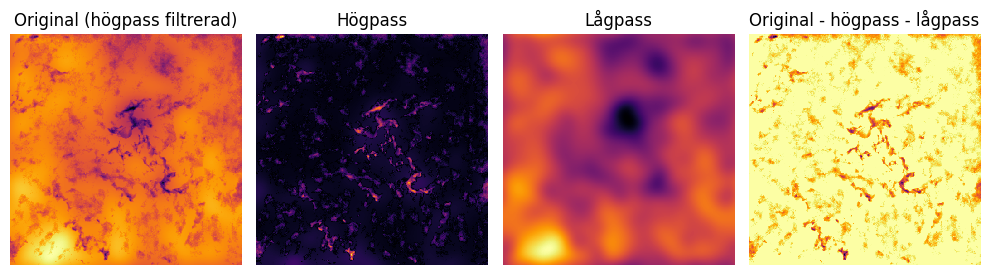

In [129]:
fig, axarr = plt.subplots(1,4)
fig.set_size_inches(10, 4.8)

fft_shift = np.fft.fftshift(np.fft.fft2(data_clipped, axes=(0,1)))

fft_masked_low = np.multiply(fft_shift, mask1)
fft_masked_high = np.multiply(fft_shift, mask2)

# plot beside each other
axarr[0].imshow(data_clipped, cmap='inferno')
axarr[0].set_title('Original (högpass filtrerad)')
axarr[0].axis('off')

img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_high)))
axarr[1].imshow(img_high_pass, cmap='inferno')
axarr[1].set_title('Högpass')
axarr[1].axis('off')

img_low_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_low)))
axarr[2].imshow(img_low_pass, cmap='inferno')
axarr[2].set_title('Lågpass')
axarr[2].axis('off')

#remove low pass from original
diff = data_clipped-img_low_pass-img_high_pass
axarr[3].imshow(diff, cmap='inferno')
axarr[3].set_title('Original - högpass - lågpass')
axarr[3].axis('off')


print("Max high pass: ", np.max(img_high_pass), "Min high pass: ", np.min(img_high_pass))
print("Max low pass: ", np.max(img_low_pass), "Min low pass: ", np.min(img_low_pass))
print("Max original: ", np.max(data), "Min original: ", np.min(data))
# shouldn't original and high pass match more?

# Numpy method
# Max high pass:  2001.001607514427 Min high pass:  1.2417589877837068e-06
# Max low pass:  262.89053097027767 Min low pass:  55.34319610907863
# Max original:  2214.1672 Min original:  47.658867

fig.tight_layout()
plt.savefig("highandlow.eps", format="eps", bbox_inches="tight", pad_inches=0)

(-0.5, 511.5, -0.5, 511.5)

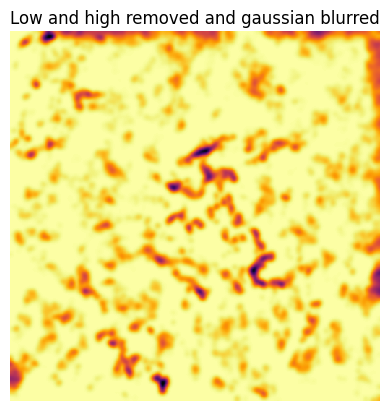

In [130]:
# blur a little
diff = scipy.ndimage.gaussian_filter(diff, sigma=3)
diff = diff - np.min(diff) # normalize to 0
plt.title("Low and high removed and gaussian blurred")
plt.imshow(diff, cmap='inferno', vmin=0)
plt.axis('off')

ASTROPY mean: 74.14011004389965 median: 75.26440778038845 stddev: 2.3804777912962805
NUMPY   mean: 71.2015314431577 median: 74.56915711167241 stddev: 7.895896776561331
threshold: 47.51384111347371


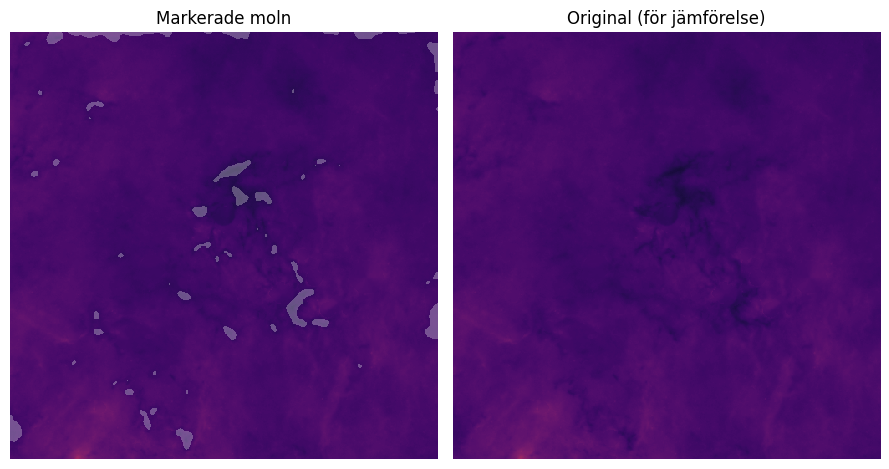

In [137]:
from matplotlib.colors import ListedColormap

mean, median, stddev = sigma_clipped_stats(diff, sigma=3)
print("ASTROPY mean:", mean, "median:", median, "stddev:", stddev)
# numpy mean median stddev
print("NUMPY   mean:", np.mean(diff), "median:", np.median(diff), "stddev:", np.std(diff))
# threshold = mean-11*stddev
threshold = np.mean(diff) - 3*np.std(diff)


# create mask by thresholding
# threshold = np.percentile(diff, 2)
print("threshold:", threshold)
mask = np.where(diff < threshold, True, False)


fig = plt.figure(figsize=(9, 4.8))

# mark areas in image
ax = fig.add_subplot(1, 2, 1)
ax.imshow(data, cmap='inferno', vmin=0, vmax=500)
cmap1 = ListedColormap(['none', 'white'])
ax.imshow(mask, cmap=cmap1, alpha=0.3)
ax.set_title('Markerade moln')
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(data, cmap='inferno', vmin=0, vmax=500)
ax.set_title('Original (för jämförelse)');
ax.axis('off')

fig.tight_layout()
plt.savefig("fouriermask.eps", format="eps", bbox_inches="tight", pad_inches=0)

Mask shape: (512, 512)


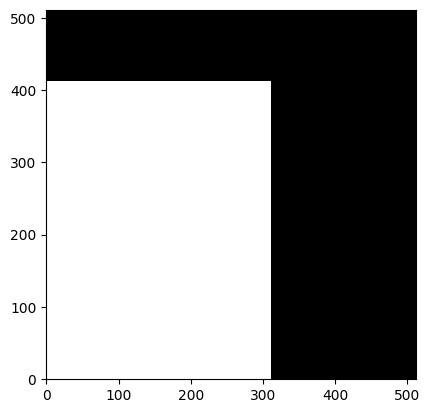

In [144]:
overlap_x = 200
overlap_y = 100

print("Mask shape:", mask.shape)

mask_overlap = np.ones(mask.shape, dtype=bool)
mask_overlap[mask.shape[0] - overlap_y: mask.shape[0], 0: mask.shape[1]] = False
mask_overlap[0: mask.shape[0], mask.shape[1] - overlap_x: mask.shape[1]] = False

plt.imshow(mask_overlap, cmap='gray')

Found objects: 56


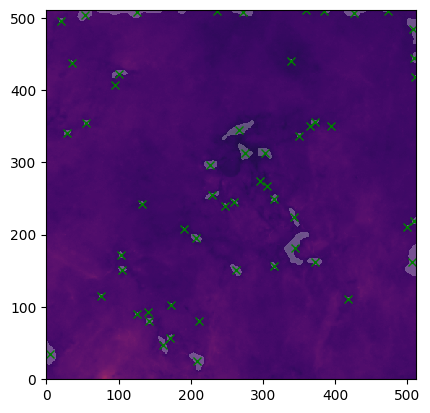

In [132]:
# detect areas in mask
labels, nlabels = scipy.ndimage.label(mask)
plt.imshow(data, cmap='inferno', vmin=0, vmax=500)

plt.imshow(mask, cmap=cmap1, alpha=0.3)

print("Found objects:", nlabels)

mass_centers = scipy.ndimage.center_of_mass(data, labels, range(1, nlabels+1))
# plot mass centers

for center in mass_centers:
    plt.plot(center[1], center[0], 'gx', alpha=1)

In [133]:
data_path = "../data/"

objects = scipy.ndimage.find_objects(labels)
dust_areas = np.array(scipy.ndimage.sum(mask, labels, range(1, nlabels+1)))

min_values = np.zeros(nlabels)
max_values = np.zeros(nlabels)
circularity = np.zeros(nlabels)
for i in range(len(mass_centers)):
    mask = labels[objects[i]] == i + 1
    min_values[i] = np.min(data[objects[i]])
    max_values[i] = np.max(data[objects[i]])
    circularity[i] = ((4 * np.pi * (np.sum(mask))) / np.power(np.sum(np.bitwise_xor(scipy.ndimage.binary_dilation(mask), mask)), 2))

output = cd.format_for_ouput(mass_centers, objects, labels, dust_areas, min_values, max_values, circularity, X, Y, data_path)
cd.save_reg_and_csv(output, "catalog_test2", data_path);

C:\Users\Emrik\AppData\Local\Temp\ipykernel_18336\157008981.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  circularity[i] = ((4 * np.pi * (np.sum(mask))) / np.power(np.sum(np.bitwise_xor(scipy.ndimage.binary_dilation(mask), mask)), 2))


51 {'x_center': 49572, 'y_center': 6508, 'approx_size': 226, 'box_x1': 49554, 'box_x2': 49587, 'box_y1': 6503, 'box_y2': 6512, 'min_value': 80.31448364257812, 'max_value': 93.54778289794922, 'circularity': 4.543999614152277, 'mask_file': '49572_6508_VjPm9cQ.npy'}


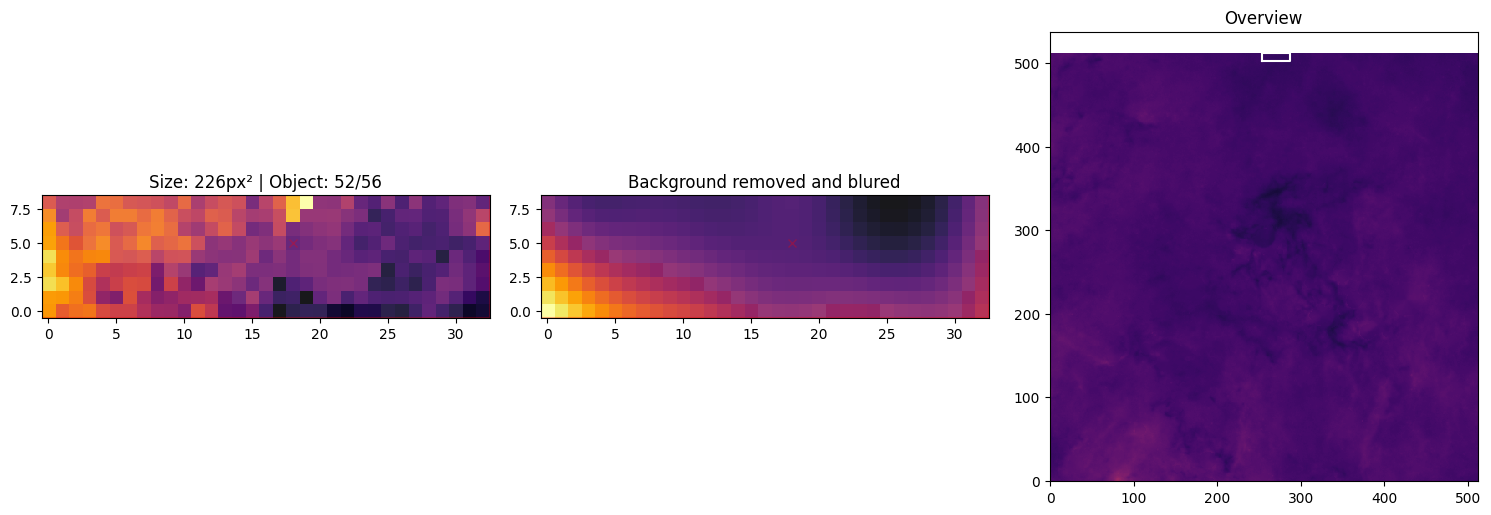

In [134]:
#FROM photutils_test.ipynb

import random
index = random.randint(0, len(output)-1)
# index = 5
padding = 50

while (output[index]["box_y1"]-Y-padding) < 0 or (output[index]["box_y2"]-Y+padding) > data.shape[0] or (output[index]["box_x1"]-X-padding) < 0 or (output[index]["box_x2"]-X+padding) > data.shape[1]:
    padding -= 1
    # print("Padding too big, set to 0")
    
print(index, output[index])

fig = plt.figure(figsize=(15, 5))

extent = (-padding-0.5, output[index]["box_x2"]+padding-output[index]["box_x1"]-0.5, -padding-0.5, output[index]["box_y2"]+padding-output[index]["box_y1"]-0.5)

rand_mask = np.load("../data/masks/"+output[index]["mask_file"])

for num in range(1,3):
    ax = fig.add_subplot(1, 3, num)

    if num == 1:
        ax.imshow(data[(output[index]["box_y1"]-Y-padding):(output[index]["box_y2"]-Y+padding), output[index]["box_x1"]-X-padding:output[index]["box_x2"]-X+padding], cmap='inferno', extent=extent)
        plt.title("Size: " + str(int(output[index]["approx_size"])) + "px² | Object: " + str(index+1) + "/" + str(len(output)))
    else:
        ax.imshow(diff[(output[index]["box_y1"]-Y-padding):(output[index]["box_y2"]-Y+padding), output[index]["box_x1"]-X-padding:output[index]["box_x2"]-X+padding], cmap='inferno', extent=extent)
        plt.title("Background removed and blured")

    ax.imshow(rand_mask, cmap=cmap1, alpha=0.1)
    ax.plot(output[index]["x_center"]-output[index]["box_x1"], output[index]["y_center"]-output[index]["box_y1"], 'rx', alpha=0.3)
    ax.plot([-0.5, output[index]["box_x2"]-output[index]["box_x1"]-0.5, output[index]["box_x2"]-output[index]["box_x1"]-0.5, -0.5, -0.5], [-0.5, -0.5, output[index]["box_y2"]-output[index]["box_y1"]-0.5, output[index]["box_y2"]-output[index]["box_y1"]-0.5, -0.5], 'r-', alpha=0.3)


ax = fig.add_subplot(1, 3, 3)
ax.imshow(data, cmap='inferno', vmin=0, vmax=500)
ax.plot([output[index]["box_x1"]-X, output[index]["box_x2"]-X, output[index]["box_x2"]-X, output[index]["box_x1"]-X, output[index]["box_x1"]-X], [output[index]["box_y1"]-Y, output[index]["box_y1"]-Y, output[index]["box_y2"]-Y, output[index]["box_y2"]-Y, output[index]["box_y1"]-Y], 'w-')
plt.title("Overview")

fig.tight_layout()
plt.show()